Denoising fMRI data using aCompCor and functional connectivity estimation
================================================

This a script for group denoising and FC estimation from on longitudinal fMRI data preprocessed in fmriprep.

Last edit: 25.07.2017

Step 1: Importing packages
------------------------------------------

In [2]:
%reset
%matplotlib inline

from os import listdir

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 

from nilearn import datasets # for fetching atlas
from nilearn import plotting 
from nilearn import input_data
from nilearn.connectome import ConnectivityMeasure

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


Step 2: Loading timeseries data
-----------------------

In [14]:
# Loading functional data
top_dir = '/home/finc/Dropbox/Projects/LearningBrain/data/neuroimaging/'
out_dir = '/home/finc/Dropbox/Projects/LearningBrain/github/LearningBrain_networks/data/neuroimaging/'


In [42]:
dual_timeseries = np.load(top_dir + "LearningBrain_dualnback_timeseries_hp_0.009_aCompCor_power.npy") 
rest_timeseries = np.load(top_dir + "LearningBrain_rest_timeseries_hp_0.009_aCompCor_power.npy") 

print(dual_timeseries.shape)
print(rest_timeseries.shape)

(46, 4, 340, 264)
(46, 4, 305, 264)


Step 3: Creating task conditions vectors
-----------------------------------------------------------

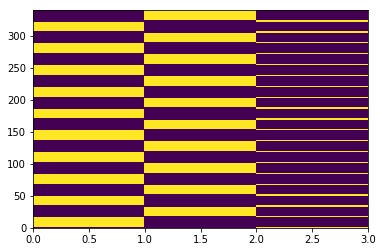

In [43]:
onsets_1back = np.array([4, 72, 140, 208, 276, 344, 412, 480, 548, 616])
onsets_2back = np.array([38, 106, 174, 242, 310, 378, 446, 514, 582, 650])

vol_num = 340

TR = 2
duration = 30

vector_n_back = np.zeros((vol_num, 3))

for i in range(len(vector_n_back)):
    if i in onsets_1back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 0] = 1
    if i in onsets_2back/TR:
        for k in range(int(duration/TR)):
            vector_n_back[i + k, 1] = 1
    else:
        continue
        
            
for i in range(len(vector_n_back)):
    if vector_n_back[i,0] == 0 and vector_n_back[i,1] == 0:
        vector_n_back[i,2] = 1
        
dual1back = vector_n_back[:,0].astype(bool)
dual2back = vector_n_back[:,1].astype(bool)

plt.pcolormesh(vector_n_back)
plt.show()


Step 4: Obtaining corelation matrices for dual
---------------------------
Creating 5D matrix with static corelation matrices for each task condition 

In [44]:
correlarion_matrices_dual = np.zeros((len(dual_timeseries[:, 0, 0, 0]), 
                                      len(dual_timeseries[0, :, 0, 0 ]),
                                      2, 
                                      len(dual_timeseries[0, 0, 0, : ]), 
                                      len(dual_timeseries[0, 0, 0, : ])))


for sub in range(len(dual_timeseries[:, 0, 0, 0])):
    for ses in range(len(dual_timeseries[0, :, 0, 0 ])):                 
        timeseries_dual1back = dual_timeseries[sub, ses, dual1back, :]
        timeseries_dual2back = dual_timeseries[sub, ses, dual2back, :]
        
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        fc1 = correlation_measure.fit_transform([timeseries_dual1back])[0]
        np.fill_diagonal(fc1, 0)
        
        fc2 = correlation_measure.fit_transform([timeseries_dual2back])[0]
        np.fill_diagonal(fc2, 0)
                     
        correlarion_matrices_dual[sub, ses, 0, :, :] = fc1
        correlarion_matrices_dual[sub, ses, 1, :, :] = fc2


np.save(out_dir + 'LearningBrain_matrices_dual_hp_0.25_aCompCor_power_.npy', correlarion_matrices_dual)      

In [45]:
correlarion_matrices_dual.shape

(46, 4, 2, 264, 264)

Step 5: Obtaining corelation matrices for resting-state
---------------------------
Creating 5D matrix with static corelation matrices for resting state condition

In [46]:
correlarion_matrices_rest = np.zeros((len(rest_timeseries[:, 0, 0, 0]), 
                                      len(rest_timeseries[0, :, 0, 0 ]),
                                      1, 
                                      len(rest_timeseries[0, 0, 0, : ]), 
                                      len(rest_timeseries[0, 0, 0, : ])))


for sub in range(len(rest_timeseries[:, 0, 0, 0])):
    for ses in range(len(rest_timeseries[0, :, 0, 0 ])):  
        
        correlation_measure = ConnectivityMeasure(kind = 'correlation')
        rest = correlation_measure.fit_transform([rest_timeseries[0, 0, :, : ]])[0]
        np.fill_diagonal(rest, 0)
                     
        correlarion_matrices_rest[sub, ses, 0, :, :] = rest
        
correlarion_matrices_rest.shape


(46, 4, 1, 264, 264)

In [65]:
corelation_matrices_all = np.concatenate((correlarion_matrices_rest, correlarion_matrices_dual), axis = 2)


In [59]:
print(correlarion_matrices_dual.shape)
print(correlarion_matrices_rest.shape)

(46, 4, 2, 264, 264)
(46, 4, 1, 264, 264)


Step 7: Plotting
---------------------------

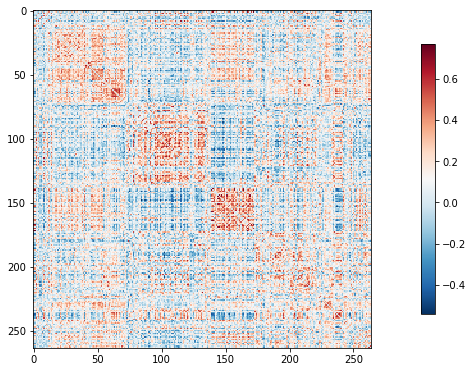

In [69]:
# 1-back

plotting.plot_matrix(corelation_matrices_all[2, 3, 1, :, :])

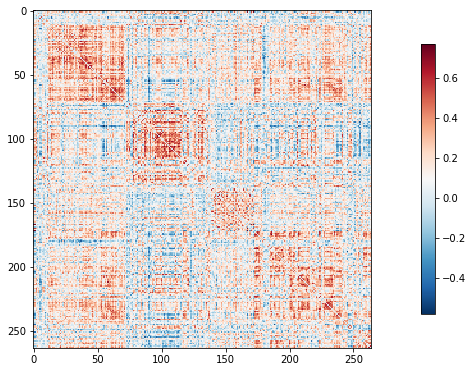

In [70]:
# 2-back

plotting.plot_matrix(corelation_matrices_all[2, 3, 2, :, :])

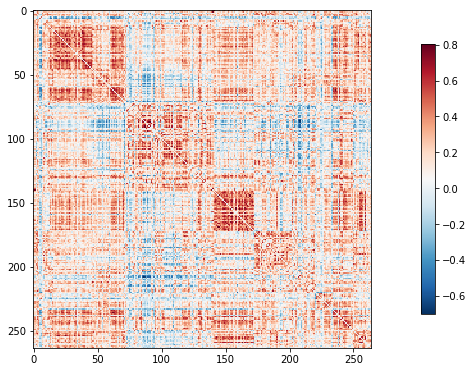

In [71]:
# 2-back

plotting.plot_matrix(corelation_matrices_all[2, 3, 0, :, :])

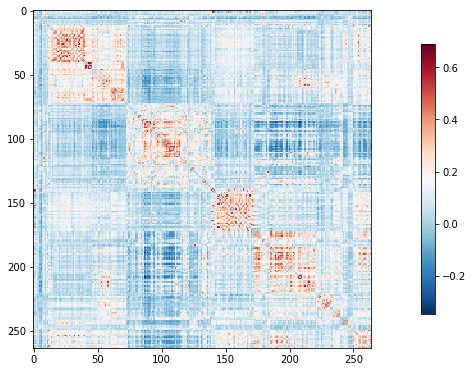

In [88]:
x = corelation_matrices_all.mean(axis = 0)
x.shape

plotting.plot_matrix(x[3, 1, :, :])